In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import sys
from pathlib import Path
# matplotlib.use("WebAgg")
import matplotlib.pyplot as plt
GIT_ROOT = Path("../..").resolve()
SRC = GIT_ROOT / "src"
if not SRC in sys.path:
    sys.path.append(str(SRC))

In [3]:
from utils.data import get_htc2022_train_phantoms, get_kits_train_phantoms, get_htclike_train_phantoms
from utils.polynomials import Legendre, Chebyshev
from geometries import FlatFanBeamGeometry, DEVICE, HTC2022_GEOMETRY, ParallelGeometry
from geometries.geometry_base import naive_sino_filling, mark_cyclic
from models.fbps import AdaptiveFBP as AFBP
from models.SerieBPs.series_bp1 import Series_BP
from models.modelbase import plot_model_progress
from statistics import mean

ar = 0.25 #angle ratio of full 360 deg scan
PHANTOM_DATA = torch.concat([get_htc2022_train_phantoms(), get_htclike_train_phantoms()])
geometry = HTC2022_GEOMETRY

SINO_DATA = geometry.project_forward(PHANTOM_DATA)

model = Series_BP(geometry, ar, 120, 60, Legendre.key)

dataset = TensorDataset(SINO_DATA, PHANTOM_DATA)
dataloader = DataLoader(dataset, batch_size=6, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-5, betas=(0.8,0.9))
mse_fn = lambda diff : torch.mean(diff**2)
n_epochs = 1000
for epoch in range(n_epochs):
    batch_losses, batch_sino_losses, batch_recon_losses = [], [], []
    for sino_batch, phantom_batch in dataloader:
        optimizer.zero_grad()

        start_ind = 0 #torch.randint(0, geometry.n_projections, (1,)).item()
        la_sinos, known_angles = geometry.zero_cropp_sinos(sino_batch, ar, start_ind)
        exp_sinos = model.get_extrapolated_sinos(la_sinos, known_angles)

        loss_sino_domain = mse_fn(exp_sinos-sino_batch)
        loss = loss_sino_domain

        loss.backward()
        optimizer.step()

        batch_losses.append(loss.cpu().item())
        batch_sino_losses.append(loss_sino_domain.cpu().item())
        batch_recon_losses.append(-1)
    
    print("Epoch:", epoch+1, "loss is:", mean(batch_losses), "sino loss is:", mean(batch_sino_losses), "recon loss is:", mean(batch_recon_losses))

Epoch: 1 loss is: 1752.59462890625 sino loss is: 1752.59462890625 recon loss is: -1
Epoch: 2 loss is: 1742.152978515625 sino loss is: 1742.152978515625 recon loss is: -1
Epoch: 3 loss is: 1754.7522216796874 sino loss is: 1754.7522216796874 recon loss is: -1
Epoch: 4 loss is: 1715.9660888671874 sino loss is: 1715.9660888671874 recon loss is: -1
Epoch: 5 loss is: 1724.702978515625 sino loss is: 1724.702978515625 recon loss is: -1
Epoch: 6 loss is: 1709.5148193359375 sino loss is: 1709.5148193359375 recon loss is: -1
Epoch: 7 loss is: 1660.6814697265625 sino loss is: 1660.6814697265625 recon loss is: -1
Epoch: 8 loss is: 1620.241552734375 sino loss is: 1620.241552734375 recon loss is: -1
Epoch: 9 loss is: 1534.63115234375 sino loss is: 1534.63115234375 recon loss is: -1
Epoch: 10 loss is: 1413.014794921875 sino loss is: 1413.014794921875 recon loss is: -1
Epoch: 11 loss is: 1225.7194458007812 sino loss is: 1225.7194458007812 recon loss is: -1
Epoch: 12 loss is: 1012.5257202148438 sino los

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Series_BP
sinogram mse: tensor(36.8700)
filterd sinogram mse:  tensor(2196.1968)
reconstruction mse:  tensor(0.1273, dtype=torch.float64)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FBP
sinogram mse: tensor(1099.7949)
filterd sinogram mse:  tensor(2194.1360)
reconstruction mse:  tensor(0.1856, dtype=torch.float64)


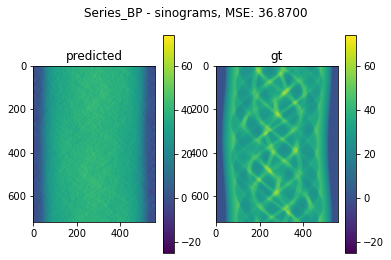

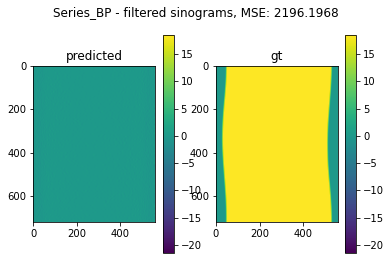

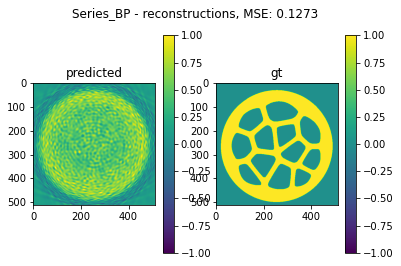

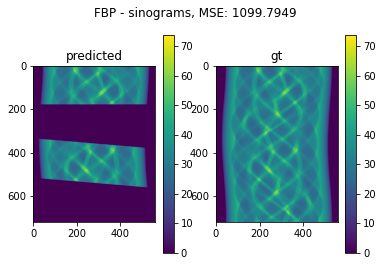

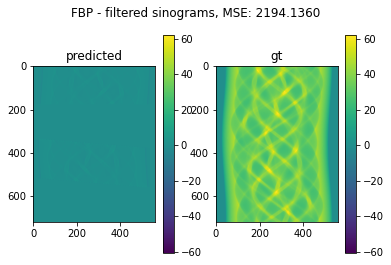

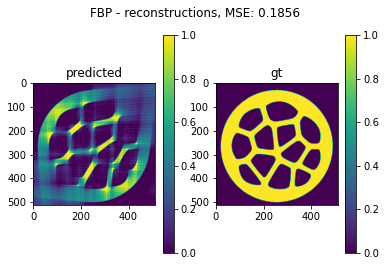

In [11]:
from models.fbps import FBP
import matplotlib
matplotlib.use("nbAgg")
plt.switch_backend("nbAgg")
fbp = FBP(model.geometry)
#Clear previous plots
for i in plt.get_fignums():
    plt.figure(i)
    plt.close()

la_sinos, known_angles = geometry.zero_cropp_sinos(SINO_DATA[:5], ar, 0)
out_angles = None
# zero_cropped_sinos = naive_sino_filling(zero_cropped_sinos, (~known_region).sum(dim=-1) == 0)
disp_ind = 2
plot_model_progress(model, SINO_DATA[:5], known_angles, out_angles, PHANTOM_DATA[:5], disp_ind=disp_ind)
plot_model_progress(fbp, SINO_DATA[:5], known_angles, out_angles, PHANTOM_DATA[:5], disp_ind=disp_ind)

plt.show()

In [ ]:
from models.modelbase import save_model_checkpoint

save_model_checkpoint(model, optimizer, loss, ar, GIT_ROOT / "data/models/series_bp_first_draft.pt")